# Data Gathering

- Importing the csv dataset downloaded from Kaggle

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as BSoup
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score       #Importing all necessary libraries

conn = sqlite3.connect('tennis_data.db')
cursor = conn.cursor()                                                              #Creating and setting up the connection to the tennis_data.db database

"""Dataset from Kaggle as .csv file, for all matches between 2000-2025"""

try:
    matches_df = pd.read_csv("/Users/shanebrady/Library/CloudStorage/OneDrive-AtlanticTU/Intro Programming for DS/Project/atp_tennis.csv")    #Loading the atp_tennis.csv data as a dataframe
except FileNotFoundError:
    raise Exception("CSV file not found. Check the file path.")                     #If there is an error loading the data then raise the exception with the error message

print(matches_df.head())                                                            #Printing the head of the dataframe
matches_df.to_sql('matches', conn, if_exists='replace', index=False)                #Adding the dataframe to the tennis_data database

                           Tournament        Date         Series    Court  \
0  Australian Hardcourt Championships  2000-01-03  International  Outdoor   
1  Australian Hardcourt Championships  2000-01-03  International  Outdoor   
2  Australian Hardcourt Championships  2000-01-03  International  Outdoor   
3  Australian Hardcourt Championships  2000-01-03  International  Outdoor   
4  Australian Hardcourt Championships  2000-01-03  International  Outdoor   

  Surface      Round  Best of        Player_1       Player_2       Winner  \
0    Hard  1st Round        3      Dosedel S.    Ljubicic I.   Dosedel S.   
1    Hard  1st Round        3      Clement A.     Enqvist T.   Enqvist T.   
2    Hard  1st Round        3       Escude N.  Baccanello P.    Escude N.   
3    Hard  1st Round        3  Knippschild J.     Federer R.   Federer R.   
4    Hard  1st Round        3     Fromberg R.  Woodbridge T.  Fromberg R.   

   Rank_1  Rank_2  Pts_1  Pts_2  Odd_1  Odd_2        Score  
0      63    

65005

- Web Scraping for the nationalities of the top 100 players

In [2]:
""" ***WEB SCRAPING*** tennisexplorer.com for nationalities of players ranked 1-100"""

columns = ['Rank', 'Move', 'Player name', 'Country', 'Points']                              #Specifyiong the name of the columns from the target table
data = []                                                                                   #Empty list so that the data can be appended

urls = [                
    "https://www.tennisexplorer.com/ranking/atp-men/",
    "https://www.tennisexplorer.com/ranking/atp-men/?page=2"
]                                                                                           #Listing the urls for page 1 and page 2

for idx, url in enumerate(urls):
    resp = requests.get(url)
    if resp.status_code != 200:
        raise Exception(f"Failed to load {url} (Status code: {resp.status_code})")          #Accessing the urls. If there is an error loading raise the exception with the error message
    
    soup = BSoup(resp.text, 'html.parser')                                                  #Creating Beautiful Soup object
    tables = soup.find_all('table')                                                         #Searching for all tables

    if len(tables) < 2:
        raise Exception(f"Expected at least 2 tables in {url}, found {len(tables)}")        #If 2 tables are not found i.e. page 1 and page 2 then raise the exception

    table = tables[1]                                                                       

    for row in table.find_all('tr')[1:]:
        cells = row.find_all(['th', 'td'])
        if len(cells) >= 5:
            row_data = [cell.text.strip() for cell in cells[:5]]
            if all(row_data):
                data.append(row_data)                                                       #Extracting the data from the web tables and storing them in data list

nationalities_df = pd.DataFrame(data, columns=columns)                                      #Creating the nationalities dataframe with the results of the web srcaping
nationalities_df.dropna(how='all', inplace=True)                                            #Dropping rows where data is missing
nationalities_df.to_sql('nationalities', conn, if_exists='replace', index=False)            #Adding the nationalites dataframe to the tennis_data database

print(nationalities_df)

    Rank Move           Player name        Country Points
0     1.    -         Sinner Jannik          Italy  10380
1     2.    1        Alcaraz Carlos          Spain   8850
2     3.    1      Zverev Alexander        Germany   7285
3     4.    -          Fritz Taylor            USA   4625
4     5.    -           Draper Jack  Great Britain   4610
..   ...  ...                   ...            ...    ...
95   96.    7          Dellien Hugo        Bolivia    641
96   97.    -  Shevchenko Alexander     Kazakhstan    630
97   98.    1        Navone Mariano      Argentina    620
98   99.    3    McDonald Mackenzie            USA    617
99  100.    2   Carreno-Busta Pablo          Spain    615

[100 rows x 5 columns]


- Web Scraping for the heights and weights of the players for analysis

In [3]:
""" ***WEB SCRAPING*** tenniscompanion.org for height and weight of players"""

columns2 = []                                                                                   #Creating empty columns2 list to append column names
data2 = []                                                                                      #Creating empty data2 list to append table data

rankings_url = "https://tenniscompanion.org/players/male/height-and-weight/"                    #Listing the url to scrape the rankings data
resp2 = requests.get(rankings_url)

if resp2.status_code != 200:
    raise Exception(f"Failed to load url {rankings_url} (Status code: {resp2.status_code})")    #Connecting to the url and raise exception if there is an error

html_content = resp2.text
soup = BSoup(html_content, 'html.parser')                                                       #Creating Beautiful Soup object

tables2 = soup.find_all('table')
if len(tables2) < 1:
    raise Exception("No tables found")
table2 = tables2[0]                                                                             #Find all the tables from the url and rasie exception if no tables were found

header_row = table2.find('tr')
for header in header_row.find_all(['th', 'td']):
    columns2.append(header.text.strip())                                                        #Extracting the column headers and appending to columns2 list

for row in table2.find_all('tr')[1:]:
    cells2 = row.find_all(['th', 'td'])
    row_data = [cell.text.strip() for cell in cells2]
    if len(cells2) == len(columns2):
        data2.append(row_data)                                                                  #Extracting the data from the table and appending to data2 list

heightweight_df = pd.DataFrame(data2, columns=columns2)                                         #Creating the heightweight dataframe with the results of the web srcaping
heightweight_df.dropna(how='all', inplace=True)                                                 #Dropping rows where data is missing
heightweight_df.to_sql('height_weight', conn, if_exists='replace', index=False)                 #Adding the heightweight dataframe to the tennis_data database

print(heightweight_df.head())       

         Last Name First Name Height (ft/in) Height (m) Height (cm)  \
0          Alcaraz     Carlos          6′ 0″       1.83         183   
1         Altmaier     Daniel          6′ 2″       1.88         188   
2          Andujar      Pablo         5′ 11″       1.80         180   
3  Auger-Aliassime      Felix          6′ 4″       1.93         193   
4             Baez  Sebastian          5′ 7″       1.70         170   

  Height (in) Weight (lbs) Weight (kg)  
0          72          193          88  
1          74          176          80  
2          71          176          80  
3          76          194          88  
4          67          154          70  


In [4]:
""" ***WEB SCRAPING*** tenniscompanion.org for age and birthdates of the players"""

columns3 = []                                                                                   #Creating empty columns3 list to append column names
data3 = []                                                                                      #Creating empty data3 list to append table data

birthdates_url = "https://tenniscompanion.org/players/male/birthdays/"                          #Listing the url to scrape the birthday data
resp3 = requests.get(birthdates_url)

if resp3.status_code != 200:
    raise Exception(f"Failed to load url {birthdates_url} (Status code: {resp3.status_code})")  #Connecting to the url and raise exception if there is an error

html_content3 = resp3.text
soup = BSoup(html_content3, 'html.parser')                                                      #Creating Beautiful Soup object

tables3 = soup.find_all('table')
if len(tables3) < 1:
    raise Exception("No tables found")
table3 = tables3[0]                                                                             #Find all the tables from the url and rasie exception if no tables were found

header_row3 = table3.find('tr')
for header in header_row3.find_all(['th', 'td']):
    columns3.append(header.text.strip())                                                        #Extracting the column headers and appending to columns3 list

for row in table3.find_all('tr')[1:]:
    cells3 = row.find_all(['th', 'td'])
    row_data = [cell.text.strip() for cell in cells3]
    if len(cells3) == len(columns3):
        data3.append(row_data)                                                                  #Extracting the data from the table and appending to data3 list

birthdate_df = pd.DataFrame(data3, columns=columns3)                                            #Creating the birthdate dataframe with the results of the web srcaping
birthdate_df.dropna(how='all', inplace=True)                                                    #Dropping rows where data is missing
birthdate_df["Birthday"] = pd.to_datetime(birthdate_df["Birthday"], errors='coerce').dt.date    #Converting the Birthday column data to a more usable format
birthdate_df.to_sql('birthdate', conn, if_exists='replace', index=False)                        #Adding the birthdate dataframe to the tennis_data database

print(birthdate_df.head())

         Last Name First Name Age    Birthday
0          Alcaraz     Carlos  22  2003-05-05
1         Altmaier     Daniel  26  1998-09-12
2          Arnaldi     Matteo  24  2000-08-08
3  Auger-Aliassime      Felix  24  2000-08-08
4  Agustin Tirante     Thiago  24  2000-08-08


- Adding dataframes to the database to be queried later

In [5]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
master_tables = cursor.fetchall()
print("Tables in the database: ", master_tables)                            #Verifying that all dataframes have been added successfully to the database

Tables in the database:  [('matches',), ('nationalities',), ('height_weight',), ('birthdate',)]


# Statistical Anlysis

1. Correlation Analysis: Average Height and Weight of players by Ranking Group

The average height (cm)/weight (kg) for the ranking group 1 - 10: 
188.00, 76.00
The average height (cm)/weight (kg) for the ranking group 11 - 20: 
187.14, 80.43
The average height (cm)/weight (kg) for the ranking group 21 - 30: 
192.00, 82.33
The average height (cm)/weight (kg) for the ranking group 31 - 40: 
187.00, 80.60
The average height (cm)/weight (kg) for the ranking group 41 - 50: 
186.43, 77.71
The average height (cm)/weight (kg) for the ranking group 51 - 60: 
188.75, 79.25
The average height (cm)/weight (kg) for the ranking group 61 - 70: 
184.00, 76.40
The average height (cm)/weight (kg) for the ranking group 71 - 80: 
179.80, 73.80
The average height (cm)/weight (kg) for the ranking group 81 - 90: 
187.00, 85.00
The average height (cm)/weight (kg) for the ranking group 91 - 100: 
No data available


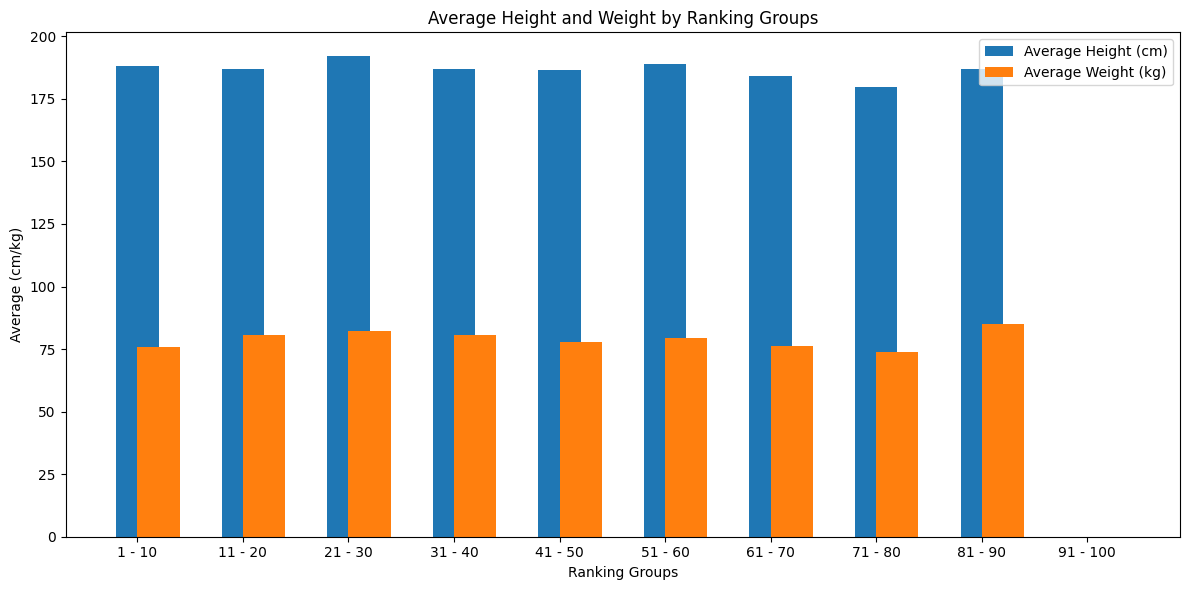

In [6]:
cursor.execute("""
    ALTER TABLE height_weight
    ADD COLUMN "Full Name" TEXT
""")                                                                #Query to add a column "Full Name" to the height_weight table

cursor.execute("""
    UPDATE height_weight
    SET "Full Name" = "Last Name" || ' ' || "First Name"               
""")                                                                #Updating the "Full Name" column by combining the first and last name of the player

conn.commit()                                                       #Commiting changes to the table

ranking_groups = []
avg_heights = []
avg_weights = []                                                    #Setting up empty lists to append the relevent data to, such as ranking group, avg height and avg weight

for rank_start in range(1, 101, 10):
    rank_end = rank_start + 9                                       #Iterate through the rankings in groups of 10 from 1 to 100 i.e 1-10, 11-20 . . .

    query = f"""
        SELECT 
            AVG(CAST("Height (cm)" AS FLOAT)) AS avg_height,
            AVG(CAST("Weight (kg)" AS FLOAT)) AS avg_weight
        FROM
            nationalities
        JOIN
            height_weight
        ON
            "Player name" = "Full Name"
        WHERE
            "Rank" BETWEEN {rank_start} AND {rank_end}
    """                                                             #Query to find the avg height and weight of a particular ranking group

    cursor.execute(query)
    result = cursor.fetchall()                                      #Gathering the results of the query

    groups = f"{rank_start} - {rank_end}"
    ranking_groups.append(groups)                                   #Appending the ranking groups to the empty ranking groups list

    print(f"The average height (cm)/weight (kg) for the ranking group {rank_start} - {rank_end}: ")
    for res in result:
        avg_height, avg_weight = res
        if avg_height is not None and avg_weight is not None:
            print(f"{res[0]:.2f}, {res[1]:.2f}")
            avg_heights.append(avg_height)
            avg_weights.append(avg_weight)                          #If the avg height and avg weight are not None then print these values while also appending them to the designated lists
        else:
            print("No data available")
            avg_heights.append(0)
            avg_weights.append(0)                                   #If the query returned None i.e. missing data then print No data available                               

x = range(len(ranking_groups))                                      #Setting up the points for the x axis of the graph

plt.figure(figsize=(12, 6))
plt.bar(x, avg_heights, width=0.4, label='Average Height (cm)', align='center')
plt.bar(x, avg_weights, width=0.4, label='Average Weight (kg)', align='edge')
plt.xlabel('Ranking Groups')
plt.ylabel('Average (cm/kg)')
plt.title('Average Height and Weight by Ranking Groups')
plt.xticks(x, ranking_groups)
plt.legend()
plt.tight_layout()
plt.show()                                                          #Plotting the avg height and weight for each ranking group available

Missing Data for ranking 91-100
- Luca Nardi height/weight
- Vit Kopriva height/weight
- Jesper De Jong height/weight
- Alexander Schevchenko height/weight

2. Comparative Analysis: Country VS Success for current top 100 players

[('Serbia', 1330), ('USA', 1226), ('France', 1048), ('Russia', 976), ('Italy', 840), ('Japan', 532), ('Germany', 481), ('Bulgaria', 442), ('Spain', 411), ('Australia', 367), ('Belgium', 336), ('Greece', 315), ('Argentina', 295), ('Great Britain', 287), ('Norway', 240), ('Poland', 215), ('Canada', 206), ('Croatia', 192), ('Kazakhstan', 176), ('Czech Republic', 169), ('Denmark', 136), ('Bosnia and Herzeg.', 107), ('Netherlands', 92), ('Chile', 54), ('Portugal', 47), ('Hungary', 39), ('China', 36), ('Bolivia', 22), ('Brazil', 14)]


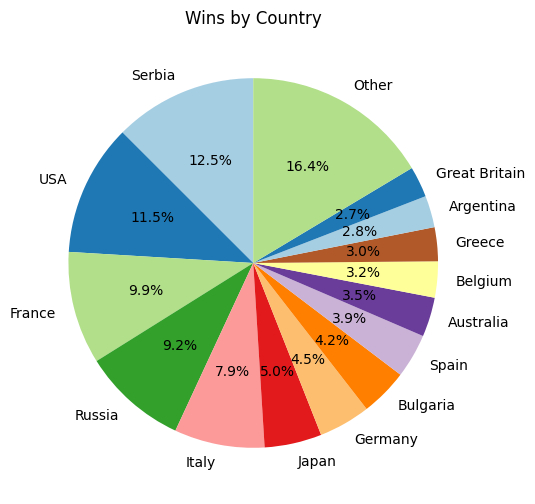

In [7]:
cursor.execute("""
    ALTER TABLE nationalities ADD COLUMN "Abbr.Name"
""")                                                         #Adding a column "Abbr.Name" to the nationalities table

cursor.execute("""
    UPDATE nationalities SET "Abbr.Name" = SUBSTR("Player name", 1, (INSTR("Player name", ' ') - 1)) || ' ' || 
               SUBSTR("Player name", (INSTR("Player name", ' ') + 1), 1) || '.'
""")                                                         #Adding theplayers surname plus first letter of first name to be consistent with other tables data i.e. Alcaraz C.

conn.commit()                                                #Commiting changes

cursor.execute("""
    SELECT
        "Country",
        COUNT(*) AS wins
    FROM 
        matches
    JOIN
        nationalities
    ON
        "Winner" = "Abbr.Name"
    GROUP BY
        "Country"
    ORDER BY
        wins DESC
""")                                                         #Query to count the number of wins by the winning players nationality

result = cursor.fetchall()
print(result)                                                #Gathering the results of the query

countries = [row[0] for row in result]                       #Creating a list of countries from query data
wins = [row[1] for row in result]                            #Creating a list for number of wins by country from query data

total_wins = sum(wins)                                       #Total number of wins and rather total number of matches
threshold = 0.025 * total_wins                               #Setting a threshold for segmenting the pie chart later (visuals)

filtered_countries = []                                      #Empty list to append countries whose total wins are greater than the set threshold
filtered_wins = []                                           #Empty list to append number of wins by country were the country is included in the filtered list (above threshold)

other_wins = 0
for country, win in zip(countries, wins):
    if win < threshold:
        other_wins += win                                    #Counting the wins by the countries that do not exceed the threshold
    else:
        filtered_countries.append(country)
        filtered_wins.append(win)                            #If the number of wins exceeds the threshold append the country and the number of wins to the respective lists
    
if other_wins > 0:                                           #Check if the other countries number of wins are not 0
    filtered_countries.append('Other')
    filtered_wins.append(other_wins)                         #Append the countries with too few wins as Other and the number of wins to the respective lists
    
plt.figure(figsize=(12, 6))
plt.pie(filtered_wins, labels=filtered_countries, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Wins by Country')
plt.show()                                                  #Plotting the Pie chart to show the sitribution of wins by country

3. Time Series: Player rankings though the years

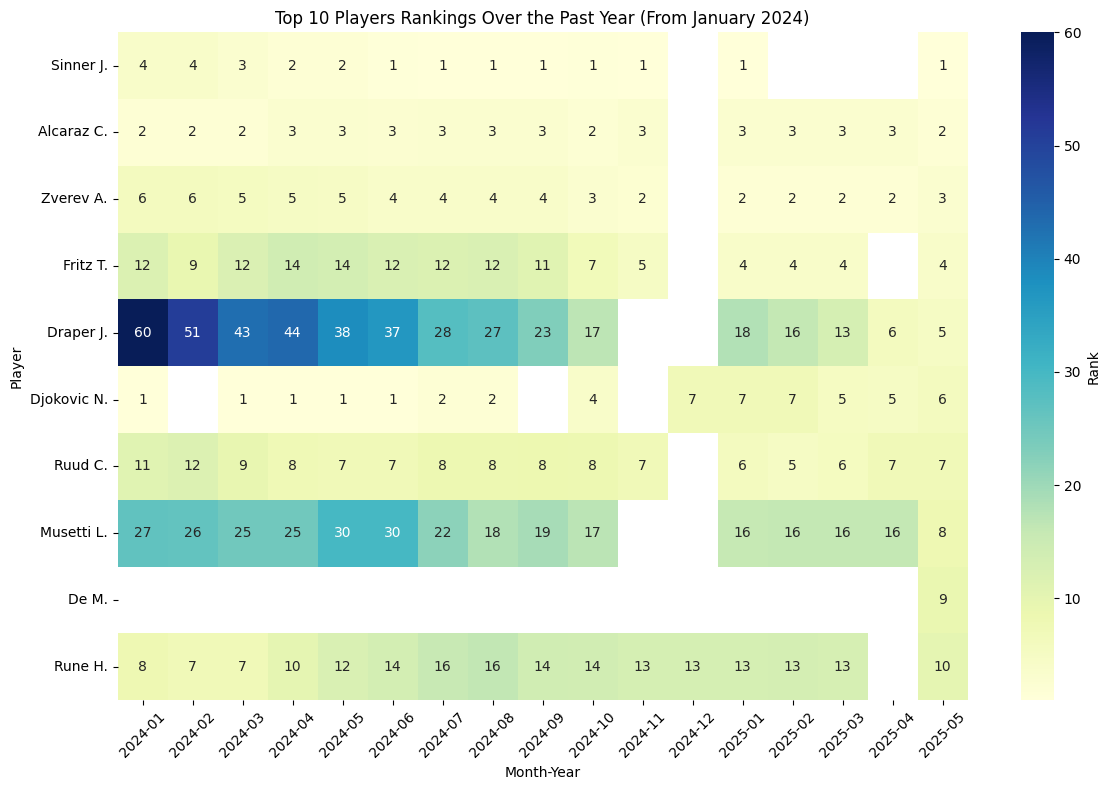

In [8]:
cursor.execute("""
WITH TopPlayers AS (
    SELECT "Abbr.Name", CAST("Rank" AS INTEGER) AS "Rank"
    FROM nationalities
    ORDER BY "Rank"
    LIMIT 10                                                                                                            -- Fetch top 10 players based on their current rank from the nationalities table
),
PlayerHistory AS (
    SELECT
        tp."Abbr.Name" AS "Player",
        strftime('%Y', m."Date") AS "Year", 
        strftime('%m', m."Date") AS "Month",
        CASE
            WHEN m."Player_1" = tp."Abbr.Name" THEN m."Rank_1"
            WHEN m."Player_2" = tp."Abbr.Name" THEN m."Rank_2"
        END AS "Rank"
    FROM
        TopPlayers tp
    LEFT JOIN
        matches m ON (m."Player_1" = tp."Abbr.Name" OR m."Player_2" = tp."Abbr.Name")                                   -- Get each player's ranking per match, grouped by month and year
)
SELECT 
    ph.Player,
    ph.Year,
    ph.Month,
    ph.Rank
FROM 
    PlayerHistory ph
ORDER BY 
    ph.Player, ph.Year, ph.Month;                                                                                       -- Order results by player name, year, and month
""")

result = cursor.fetchall()                                                                                              #Fetching the results of the query
results_df = pd.DataFrame(result, columns=['Player', 'Year', 'Month', 'Rank'])                                          #Creating the data frame with the results of the query

results_df['YearMonth'] = results_df['Year'].astype(str) + '-' + results_df['Month'].astype(str).str.zfill(2)           #Creating YearMonth column to be used for plotting and sorting
results_df = results_df[results_df['YearMonth'] >= '2024-01']                                                           #Sorting the results to only display the players rank since Jan 2024

cursor.execute("""
SELECT "Abbr.Name", CAST("Rank" AS INTEGER) AS "Rank"
FROM nationalities
ORDER BY "Rank"
LIMIT 10
""")                                                                                                                    #Query to simply gather current top 10 ranked players

player_rank_data = cursor.fetchall()                                                                                    #Gathering the results of the new query
player_rank_df = pd.DataFrame(player_rank_data, columns=['Player', 'Rank'])                                             #Creating a data frame with results of new query

current_ranks = player_rank_df.set_index('Player')['Rank'].to_dict()                                                    #Creating a dictionary for easy access to the players and ranks

may_2025_data = []
for player in player_rank_df['Player']:
    may_2025_data.append([player, 2025, 5, current_ranks[player]])                                                      #Adding the current rankings of the top 10 players as of may 2025 as the matches table is not up to date (only up to mid April)

may_2025_df = pd.DataFrame(may_2025_data, columns=['Player', 'Year', 'Month', 'Rank'])                                  #Creating a data frame for may 2025 players and ranks

results_df = pd.concat([results_df, may_2025_df], ignore_index=True)                                                    #Appending may 2025 to the results data frame for a complete up to date rankings

results_df['YearMonth'] = results_df['Year'].astype(str) + '-' + results_df['Month'].astype(str).str.zfill(2)           #Ensuring the yearmonth column is correctly updated with May 2025

df_pivot = results_df.pivot_table(index='Player', columns='YearMonth', values='Rank')                                   #Creating a pivot table to be used in the heat map with players, date and ranking values

df_pivot = df_pivot.loc[:, ~df_pivot.columns.str.contains('None-None')]                                                 #Remove any invalid columns like None-None

ordered_players = player_rank_df['Player'].tolist()                                                                     #Get ordered list of players i.e 1-10 in a row
df_pivot = df_pivot.loc[ordered_players]                                                                                #Reorder the pivot to reflect the order of players


plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Rank'}, fmt='.0f')
plt.title('Top 10 Players Rankings Over the Past Year (From January 2024)')
plt.xlabel('Month-Year')
plt.ylabel('Player')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()                                                                                                              #Plotting the heat map of top 10 players rankings over the past year


4. Hypothesis Testing: Are young players performing better in recent years.

Null Hypothesis (H0): There is no significant difference in performance between young and older players in recent years
Alternative Hypothesis (H1): Young players perform better in recent years

In [9]:
cursor.execute("""
    ALTER TABLE birthdate ADD COLUMN "Abbr.Name"
""")                                                                                                #Query to add the column "Abbr.Name" to the birthdate table

cursor.execute("""
    UPDATE birthdate SET "Abbr.Name" = "Last Name" || ' ' || SUBSTR("First Name", 1, 1) || "."
""")                                                                                                #Updating the "Abbr.Name" column to match the format in other tables for joining

conn.commit()           #Commiting the changes


In [10]:
cursor.execute("""
    WITH MatchData AS (
        SELECT
            m."Winner",
            m."Date",
            CAST(strftime('%Y', m."Date") AS INTEGER) AS match_year,
            b."Birthday",
            (CAST(strftime('%Y', m."Date") AS INTEGER) - CAST(strftime('%Y', b."Birthday") AS INTEGER)) -
            (CAST(strftime('%m-%d', m."Date") < strftime('%m-%d', b."Birthday") AS INTEGER)) AS Age
        FROM
            matches m
        JOIN
            birthdate b ON m."Winner" = b."Abbr.Name"
        WHERE
            m."Date" IS NOT NULL   
            AND b."Birthday" IS NOT NULL
            AND CAST(strftime('%Y', m."Date") AS INTEGER) BETWEEN 2020 AND 2025
    ),                                                                                                      -- Extracting match winner and their age at the time of the match                          

    AgeGroups AS (
        SELECT
            match_year,
            CASE
                WHEN Age < 25 THEN 'Young'
                ELSE 'Older'
            END AS Age_group
        FROM MatchData
    ),                                                                                                      -- Categorizing players into 'Young' (<25) and 'Older' groups

    Counts AS (
        SELECT
            match_year,
            Age_group,
            COUNT(*) AS win_count
        FROM AgeGroups
        GROUP BY match_year, Age_group
    ),                                                                                                      -- Counting the number of wins per age group per year
               
    TotalPerYear AS (
        SELECT
            match_year,
            SUM(win_count) AS total_wins
        FROM Counts
        GROUP BY match_year
    )                                                                                                       -- Calculating total wins per year for percentage calculations

    SELECT
        c.match_year,
        c.Age_group,
        c.win_count,
        ROUND(1.0 * c.win_count / t.total_wins, 3) AS win_percentage
    FROM Counts c
    JOIN TotalPerYear t ON c.match_year = t.match_year
    ORDER BY c.match_year, c.Age_group;                                                                     -- For each year and age group, show win count and percentage of total wins
""")                                                                                                                                                 

results = cursor.fetchall()
print(results)                                                                                              #Fetching the results of the query

oldyoung_df = pd.DataFrame(results, columns=['match_year', 'Age_group', 'win_count', 'win_percentage'])     #Creating the data frame with the results

young_group = oldyoung_df[oldyoung_df['Age_group'] == 'Young']['win_count']                 
older_group = oldyoung_df[oldyoung_df['Age_group'] == 'Older']['win_count']                                 #Separating the data into young and older player win counts

t_stat, p_val = ttest_ind(young_group, older_group, equal_var=False)                                        #Perform t - test to compare average wins per group

print(f"\n T-statistic: {t_stat:.3f}, P-value: {p_val:.3f}")

# Print the average wins for each group
print(f"\nYoung players' average wins: {young_group.mean():.2f}")
print(f"Older players' average wins: {older_group.mean():.2f}")


[(2020, 'Older', 430, 0.477), (2020, 'Young', 472, 0.523), (2021, 'Older', 986, 0.532), (2021, 'Young', 869, 0.468), (2022, 'Older', 1219, 0.571), (2022, 'Young', 917, 0.429), (2023, 'Older', 1297, 0.665), (2023, 'Young', 654, 0.335), (2024, 'Older', 1527, 0.754), (2024, 'Young', 499, 0.246), (2025, 'Older', 475, 0.774), (2025, 'Young', 139, 0.226)]

 T-statistic: -1.821, P-value: 0.104

Young players' average wins: 591.67
Older players' average wins: 989.00


Since the P-value is greater than 0.05, we do not have strong enough evidence to say that younger players are performing better than older players in recent years.

5. Surface-Specific player performance: Are certain players better suited to a particular playing surface?

    Player Name  Total Clay Matches  Total Grass Matches  Total Hard Matches  \
77    Sinner J.                  73                   29                 218   
0    Alcaraz C.                  92                   27                 142   
87    Zverev A.                 200                   58                 359   
29     Fritz T.                  81                   55                 311   
22    Draper J.                  19                   22                  87   
21  Djokovic N.                 324                  131                 762   
71      Ruud C.                 209                   14                 163   
57   Musetti L.                  87                   26                 115   
70      Rune H.                  71                   17                 131   
50  Medvedev D.                  66                   66                 369   

    No. Clay Wins  No. Grass Wins  No. Hard Wins  Current Rank  \
77             52              21            174     

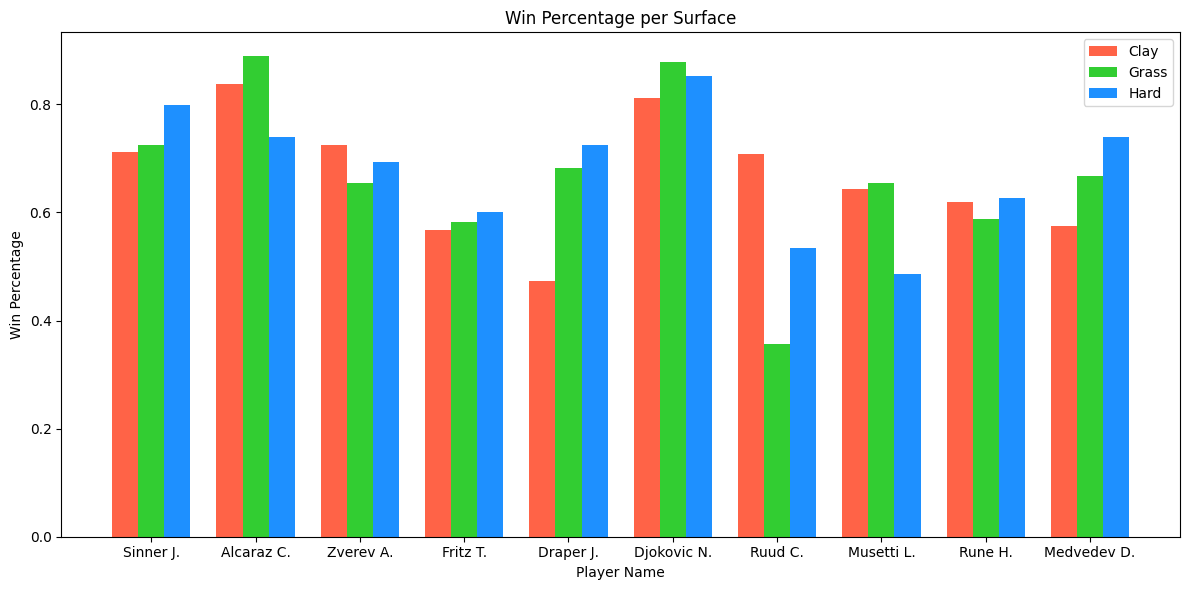

In [11]:
cursor.execute("""
    SELECT
        n."Abbr.Name" AS player_name,
        SUM(CASE WHEN m."Surface" = 'Clay' AND (m."Player_1" = n."Abbr.Name" OR m."Player_2" = n."Abbr.Name") THEN 1 ELSE 0 END) AS total_matches_clay, 
        SUM(CASE WHEN m."Surface" = 'Grass' AND (m."Player_1" = n."Abbr.Name" OR m."Player_2" = n."Abbr.Name") THEN 1 ELSE 0 END) AS total_matches_grass,
        SUM(CASE WHEN m."Surface" = 'Hard' AND (m."Player_1" = n."Abbr.Name" OR m."Player_2" = n."Abbr.Name") THEN 1 ELSE 0 END) AS total_matches_hard,      -- Counting total matches played on each surface
        SUM(CASE WHEN m."Surface" = 'Clay' AND m."Winner" = n."Abbr.Name" THEN 1 ELSE 0 END) AS clay_wins,
        SUM(CASE WHEN m."Surface" = 'Grass' AND m."Winner" = n."Abbr.Name" THEN 1 ELSE 0 END) AS grass_wins,
        SUM(CASE WHEN m."Surface" = 'Hard' AND m."Winner" = n."Abbr.Name" THEN 1 ELSE 0 END) AS hard_wins,                                                   -- Counting match wins by player on each surface
        n."Rank"                                                                                                                                             -- Include players current rank
    FROM
        matches m
    JOIN
        nationalities n ON n."Abbr.Name" = m."Player_1" OR n."Abbr.Name" = m."Player_2"
    GROUP BY
        n."Abbr.Name";
""")

results = cursor.fetchall()                                                                                     #fetching the query results

percentage_df = pd.DataFrame(results, columns=['Player Name', 'Total Clay Matches', 'Total Grass Matches', 'Total Hard Matches', 'No. Clay Wins', "No. Grass Wins", "No. Hard Wins", "Current Rank"])   #Creating a data frame from the query results
percentage_df['Win Percentage Clay'] = percentage_df['No. Clay Wins'] / percentage_df['Total Clay Matches']
percentage_df['Win Percentage Grass'] = percentage_df['No. Grass Wins'] / percentage_df['Total Grass Matches']
percentage_df['Win Percentage Hard'] = percentage_df['No. Hard Wins'] / percentage_df['Total Hard Matches']     #Calculating win percentages for each surface
percentage_df['Current Rank'] = pd.to_numeric(percentage_df['Current Rank'], errors='coerce')                   #Converting the rank column to numeric 

top10 = percentage_df.sort_values(by='Current Rank', ascending=True).head(10)                                   #Selcting the top 10 players based on current rank
print(top10)

x = np.arange(len(top10))
width = 0.25                                                                                                    #Plotting set up for grouped bar chart

color_clay = '#FF6347'  # Tomato red for Clay
color_grass = '#32CD32'  # Lime green for Grass
color_hard = '#1E90FF'  # Dodger blue for Hard

plt.figure(figsize=(12, 6))
plt.bar(x - width, top10['Win Percentage Clay'], width, label='Clay', color=color_clay)
plt.bar(x, top10['Win Percentage Grass'], width, label='Grass', color=color_grass)
plt.bar(x + width, top10['Win Percentage Hard'], width, label='Hard', color=color_hard)
plt.xlabel('Player Name')
plt.ylabel('Win Percentage')
plt.title('Win Percentage per Surface')
plt.xticks(x, top10['Player Name'])
plt.legend()
plt.tight_layout()
plt.show()                                                                                                      #Plotting grouped bar chart for win percentages per surface for the players


6. Score Analysis: Are matches on specific surfaes longer than others?

In [12]:
cursor.execute("""
    SELECT "Surface", "Score" FROM matches
""")                                            #Query extracting surface type and score from matches table

results = cursor.fetchall()                     #fetching results

score_df = pd.DataFrame(results, columns=['Surface', 'Score'])  #Creating the data from query results
print(score_df.head())

def count_total_games(score):                   #Function to calculate total number of games in a match based on the score string
    if pd.isnull(score):                        #Handle Null or missing values
        return 0
    total_games = 0
    sets = str(score).strip().split()           #Split score by whitespace to get individual set scores
    for set_score in sets:
        try:
            games = set_score.split('-')        #Split each set into two individual numbers, representing the games of each player
            if len(games) == 2:
                total_games += int(games[0]) + int(games[1])    #Add bot players games for the set
        except ValueError:
            continue                            #Skip set scores formatted differently i.e. tiebreaks and walkovers 
    return total_games

score_df['Total Games'] = score_df['Score'].apply(count_total_games)    #Applying the function to the score column

avg_games_per_surface = score_df.groupby('Surface')['Total Games'].mean().round(0).astype(int).sort_values(ascending=False) #Group by surface and compute average number of games per match

for surface, avg_games in avg_games_per_surface.items():
    print(f"{surface}: {avg_games} games on average")

  Surface        Score
0    Hard      6-4 6-2
1    Hard      3-6 3-6
2    Hard  6-7 7-5 6-3
3    Hard      1-6 4-6
4    Hard  7-6 5-7 6-4
Grass: 29 games on average
Hard: 26 games on average
Clay: 25 games on average
Carpet: 24 games on average


7. Predictive Modelling using Multivariate Logistic Regression: Predicting Match winner on various criteria like surface type and rank

In [13]:
cursor.execute("""
    SELECT
        m."Surface",
        m."Player_1",
        m."Player_2",
        n1."Rank" AS rank1,
        n2."Rank" AS rank2,
        CASE WHEN m."Winner" = m."Player_1" THEN 1 ELSE 0 END AS win1
    FROM
        matches m
    JOIN
        nationalities n1 ON m."Player_1" = n1."Abbr.Name"
    JOIN
        nationalities n2 ON m."Player_2" = n2."Abbr.Name"
""")                                                                                #Query to retrieve match details like surface type, players, ranks and winners

results = cursor.fetchall()                                                         #fetching the results of the query

prediction_df = pd.DataFrame(results, columns=['Surface', 'Player_1', 'Player_2', 'Rank1', 'Rank2', 'Win1'])    #Creating a data frame on the results of the query

percentage_p1 = percentage_df.rename(columns={
    'Player Name': 'Player_1',
    'Win Percentage Clay': 'P1_WinRate_Clay',
    'Win Percentage Grass': 'P1_WinRate_Grass',
    'Win Percentage Hard': 'P1_WinRate_Hard'
})                                                                                  #Renaming win percentage columns for player 1 from previous percentage dataframe

prediction_df = prediction_df.merge(
    percentage_p1[['Player_1', 'P1_WinRate_Clay', 'P1_WinRate_Grass', 'P1_WinRate_Hard']],
    on='Player_1', how='left'
)                                                                                   #Merging Player 1's win percentages into main DataFrame

percentage_p2 = percentage_df.rename(columns={
    'Player Name': 'Player_2',
    'Win Percentage Clay': 'P2_WinRate_Clay',
    'Win Percentage Grass': 'P2_WinRate_Grass',
    'Win Percentage Hard': 'P2_WinRate_Hard'
})                                                                                  #Renaming win percentage columns for player 2 from previous percentage dataframe

prediction_df = prediction_df.merge(
    percentage_p2[['Player_2', 'P2_WinRate_Clay', 'P2_WinRate_Grass', 'P2_WinRate_Hard']],
    on='Player_2', how='left'
)                                                                                   #Merging Player 2's win percentages into main DataFrame

def get_surface_winrate_diff(row):                                                  #Function to compute win rate difference for each surface type
    if row['Surface'] == 'Clay':
        return row['P1_WinRate_Clay'] - row['P2_WinRate_Clay']
    elif row['Surface'] == 'Grass':
        return row['P1_WinRate_Grass'] - row['P2_WinRate_Grass']
    elif row['Surface'] == 'Hard':
        return row['P1_WinRate_Hard'] - row['P2_WinRate_Hard']
    else:
        return 0                                                                            #fallback if surface is unknown or missing

prediction_df['WinRate_Diff'] = prediction_df.apply(get_surface_winrate_diff, axis=1)       #Applying the function to calculate win rate difference per surface type
prediction_df.dropna(subset=['WinRate_Diff'], inplace=True)                                 #Drop rows with missing win rate differences

                                                                                            
prediction_df['Rank1'] = pd.to_numeric(prediction_df['Rank1'], errors='coerce')             #Converting the Rank 1 column to numeric values
prediction_df['Rank2'] = pd.to_numeric(prediction_df['Rank2'], errors='coerce')             #Converting the Rank 2 column to numeric values
prediction_df.dropna(subset=['Rank1', 'Rank2'], inplace=True)                               #Dropping rows where Rank 1 or 2 are NaN
prediction_df['Rank_Diff'] = prediction_df['Rank2'] - prediction_df['Rank1']                #Calculating the rank difference between player 1 and 2

X = prediction_df[['WinRate_Diff', 'Rank_Diff']]                                            #Features: win rate per surface difference and rank difference
y = prediction_df['Win1']                                                                   #Target: 1 if Player 1 won or 0 if Player 1 lost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   # Split into training and test sets

model = LogisticRegression(fit_intercept=False, solver='liblinear')                         #Initialising the logistic regression
model.fit(X_train, y_train)                                                                 #Training the model

y_pred = model.predict(X_test)                                                              #Predicting the target variable on the test set

print("Accuracy:", accuracy_score(y_test, y_pred))
precision = precision_score(y_test, y_pred)
print("Precision:", precision)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))                              #Printing result of the regression like accuracy and precision along with the confusion matrix


Accuracy: 0.6835781041388518
Precision: 0.7048346055979644
Confusion Matrix:
 [[235 116]
 [121 277]]
